In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt

2023-05-03 02:12:31.109781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=40)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        labels.append(label)
        image = cv2.imread(image_path, 0)
        gray_img_eqhist=cv2.equalizeHist(image)
        gray_clahe_image = cv2.cvtColor(clahe.apply(gray_img_eqhist), cv2.COLOR_GRAY2RGB)
        image = tf.image.resize(gray_clahe_image, (229, 229)).numpy().astype("uint8")
        images.append(image)
    return images, labels

In [4]:
train = pd.read_csv("../CBIS-DDSM/csv/mass_train_updated.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/mass_test_updated.csv", index_col=0)

In [5]:
new_dataset_train_path = "../image_dataset/calc_dataset/cropped_images/train/"
new_dataset_val_path = "../image_dataset/calc_dataset/cropped_images/validation/"
# test_dataset_path = "../preprocessed_dataset/validation/"

In [6]:
train.columns

Index(['index', 'patient_id', 'breast_density', 'left or right breast',
       'image view', 'abnormality id', 'abnormality type', 'mass shape',
       'mass margins', 'assessment', 'pathology', 'subtlety',
       'image file path', 'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [7]:
BATCH_SIZE = 256

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(229, 229))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(229, 229))

# test_dataset = tf.keras.utils.image_dataset_from_directory(test_dataset_path,
#                                                                  shuffle=True,
#                                                                  batch_size=BATCH_SIZE,
#                                                                    image_size=(229, 229))

images, labels = generate_test_data(test, image_type_path="cropped image file path")

Found 1497 files belonging to 2 classes.
Metal device set to: Apple M1
Found 333 files belonging to 2 classes.


2023-05-03 02:12:33.400903: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-03 02:12:33.401097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-05-03 02:12:34.758051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [333]
	 [[{{node Placeholder/_4}}]]
2023-05-03 02:12:34.758577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [333]
	 [[{{node Placeholder/_4}}]]


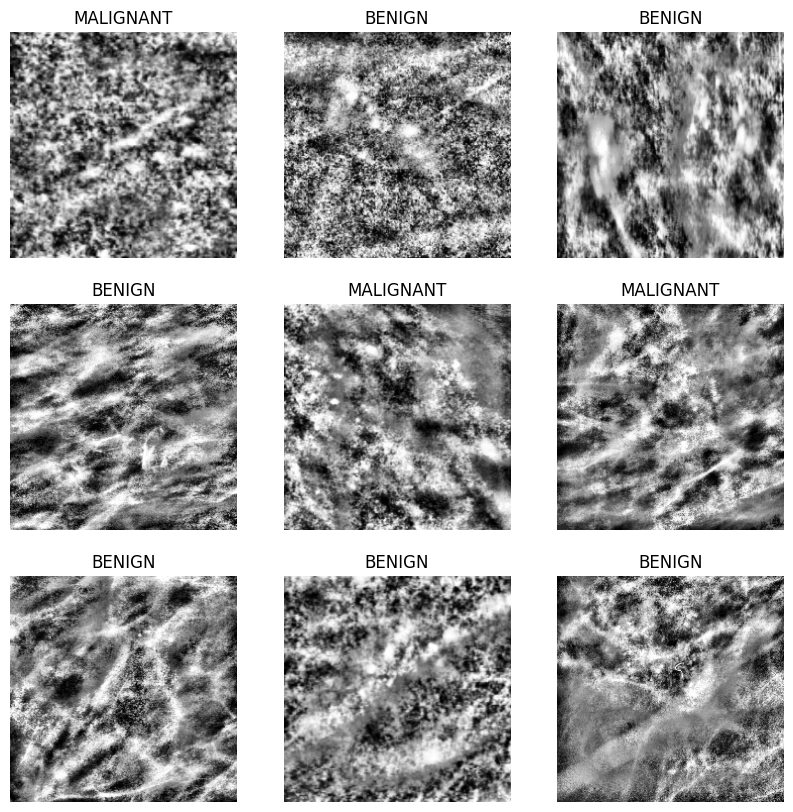

In [8]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [10]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(229, 229, 3),  weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(229, 229, 3))

# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [11]:
history = model.fit(tf_train_dataset,
                    epochs=50,
                    batch_size=256,
                    validation_data=tf_validation_dataset)

mets = model.evaluate(images, labels)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/50


2023-05-03 02:12:38.364615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1497]
	 [[{{node Placeholder/_0}}]]
2023-05-03 02:12:38.364931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1497]
	 [[{{node Placeholder/_0}}]]
2023-05-03 02:12:40.151327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.9478 - accuracy: 0.4923

2023-05-03 02:12:51.793199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [333]
	 [[{{node Placeholder/_4}}]]
2023-05-03 02:12:51.794037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [333]
	 [[{{node Placeholder/_0}}]]
2023-05-03 02:12:52.628112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 18s 3s/step - loss: 0.9478 - accuracy: 0.4923 - val_loss: 0.8736 - val_accuracy: 0.5075
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 0.8713 - accuracy: 0.5003 - val_loss: 0.7197 - val_accuracy: 0.5345
Epoch 3/50
6/6 [==============================] - 12s 2s/step - loss: 0.7824 - accuracy: 0.5451 - val_loss: 0.7013 - val_accuracy: 0.5405
Epoch 4/50
6/6 [==============================] - 12s 2s/step - loss: 0.7566 - accuracy: 0.5337 - val_loss: 0.6814 - val_accuracy: 0.5345
Epoch 5/50
6/6 [==============================] - 12s 2s/step - loss: 0.7074 - accuracy: 0.5578 - val_loss: 0.6755 - val_accuracy: 0.5495
Epoch 6/50
6/6 [==============================] - 12s 2s/step - loss: 0.7061 - accuracy: 0.5531 - val_loss: 0.6632 - val_accuracy: 0.5616
Epoch 7/50
6/6 [==============================] - 12s 2s/step - loss: 0.6796 - accuracy: 0.5812 - val_loss: 0.6527 - val_accuracy: 0.5946
Epoch 8/50
6/6 [=============================

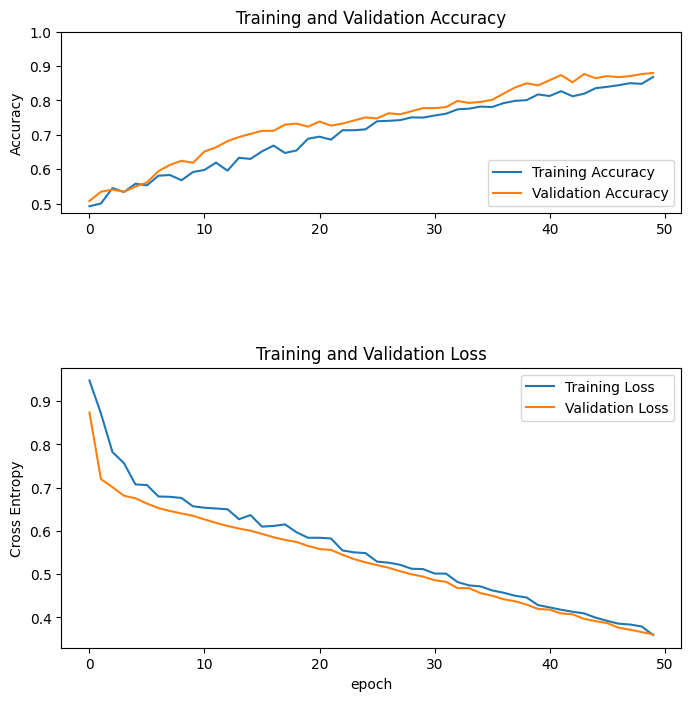

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()